# Sparse sampling

In this page, we describe how to infer IR expansion coefficients using the sparse-sampling techiniques.

In [1]:
import sparse_ir
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Set up
We consider a semicircular spectral modeli (full bandwidth of 2):

$$
\rho(\omega) = \frac{2}{\pi}\sqrt{1-\omega^2}.
$$

First, we compute the numerically exact expansion coefficients $g_l$.

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/sparse_ir/basis.py:292: UserWarning: 
Basis cutoff is 1e-15, which is below sqrt(eps) with
eps = 2.2e-16.  Expect singular values and basis functions
for large l to have lower precision than the cutoff.
You can install the xprec package to gain more precision.

  sve_result = sve.compute(self._kernel, eps)


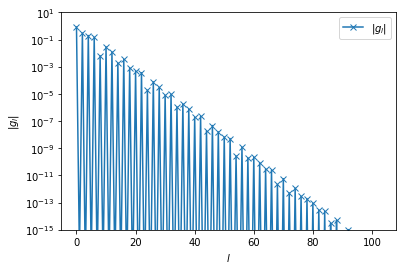

In [2]:
def rho(omega):
    if np.abs(omega) < 1:
        return (2/np.pi) * np.sqrt(1-omega**2)
    else:
        return 0.0

beta = 1000
wmax = 10
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=1e-15)

rhol = basis.v.overlap(rho)
gl = - basis.s * rhol

plt.semilogy(np.abs(gl), marker="x", label=r"$|g_l|$")
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")
plt.ylim([1e-15, 10])
plt.legend()
plt.show()

## From sampling times

We first create a `TauSampling` object for the default sampling times.

In [3]:
smpl_tau = sparse_ir.TauSampling(basis)
print("sampling times: ", smpl_tau.sampling_points)
print("Condition number: ", smpl_tau.cond)

sampling times:  [9.89903246e-03 1.97980649e-02 4.02518231e-02 4.06480568e-02
 6.59907157e-02 9.44362240e-02 9.47543762e-02 1.16173849e-01
 1.66169624e-01 1.67247415e-01 2.06636082e-01 3.15738891e-01
 4.45069618e-01 6.08696374e-01 6.64264422e-01 6.65080834e-01
 8.05490934e-01 9.24671175e-01 9.25931690e-01 1.03231277e+00
 1.28641293e+00 1.48643151e+00 2.02096482e+00 2.29623603e+00
 2.72023795e+00 3.25781780e+00 3.81281689e+00 4.48710254e+00
 4.93133562e+00 6.09110497e+00 7.07287299e+00 8.19429949e+00
 9.47354155e+00 1.09696747e+01 1.17976352e+01 1.45986747e+01
 1.68952374e+01 1.94895866e+01 2.24552053e+01 2.58977921e+01
 2.98872057e+01 3.44102172e+01 3.97255879e+01 4.57736524e+01
 5.27100998e+01 6.07549436e+01 6.99749948e+01 8.05114829e+01
 9.26866155e+01 1.06532307e+02 1.22551862e+02 1.40615060e+02
 1.61218638e+02 1.84477934e+02 2.10855779e+02 2.40396879e+02
 2.73017504e+02 3.08855290e+02 3.47618962e+02 3.89042587e+02
 4.32526077e+02 4.77386024e+02 5.22613976e+02 5.67473923e+02
 6.1095

The condition number is around 50, indicating that 1--2 significant digits may be lost in a fit from the sampling times. Let us fit from the sampling times!

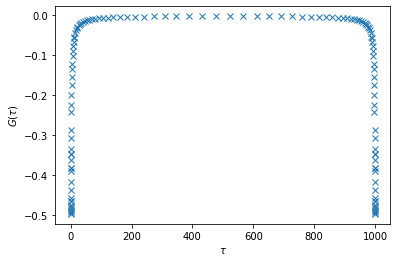

In [4]:
# Evaluate G(τ) on the sampling times
gtau_smpl = smpl_tau.evaluate(gl)
plt.plot(smpl_tau.sampling_points, gtau_smpl, marker="x", ls="")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")
plt.show()

# Fit G(τ) on the sampling times
gl_reconst_from_tau = smpl_tau.fit(gtau_smpl)

## From sampling frequencies

We create a `MatsubaraSampling` object for the default sampling frequencies.

In [5]:
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
print("sampling frequencies: ", smpl_matsu.sampling_points)
print("Condition number: ", smpl_matsu.cond)

sampling frequencies:  [-415361 -395581 -375801 -359123 -341317 -336261 -320613 -292151 -243631
 -231103 -220085 -213431 -196129 -185455 -171155 -158017  -97053  -90871
  -82447  -76357  -38557  -37185  -35239  -34153  -31739  -14107   -8759
   -6027   -4633   -3679   -3001   -2485   -2085   -1763   -1505   -1291
   -1107    -953    -823    -711    -615    -533    -461    -399    -345
    -301    -261    -225    -195    -169    -147    -127    -111     -97
     -83     -73     -63     -55     -49     -41     -37     -33     -29
     -25     -23     -21     -19     -17     -15     -13     -11      -9
      -7      -5      -3      -1       1       3       5       7       9
      11      13      15      17      19      21      23      25      29
      33      37      41      49      55      63      73      83      97
     111     127     147     169     195     225     261     301     345
     399     461     533     615     711     823     953    1107    1291
    1505    1763    2085    

The condition number is slightly larger than that for the sampling times.

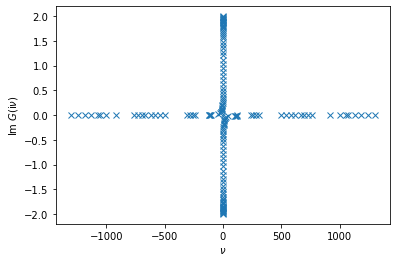

In [6]:
# Evaluate G(iv) on the sampling frequencies
giv_smpl = smpl_matsu.evaluate(gl)
plt.plot((np.pi/beta)*smpl_matsu.wn, giv_smpl.imag, marker="x", ls="")
plt.xlabel(r"$\nu$")
plt.ylabel(r"Im $G(\mathrm{i}\nu)$")
plt.show()

# Fit G(τ) on the sampling times
gl_reconst_from_matsu = smpl_matsu.fit(giv_smpl)

## Comparison with exact results
We now compare the reconstructed expansion coefficients with the exact one. For clarity, we plot only the data for even $l$.

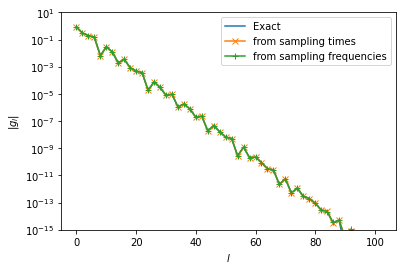

In [7]:
ls = np.arange(basis.size)
plt.semilogy(ls[::2], np.abs(gl[::2]), marker="", ls="-", label="Exact")
plt.semilogy(ls[::2], np.abs(gl_reconst_from_tau[::2]), marker="x", label="from sampling times")
plt.semilogy(ls[::2], np.abs(gl_reconst_from_matsu[::2]), marker="+", label="from sampling frequencies")
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")
plt.ylim([1e-15, 10])
plt.legend()
plt.show()

We saw a perfect match! Let us plot the differences from the exact one.

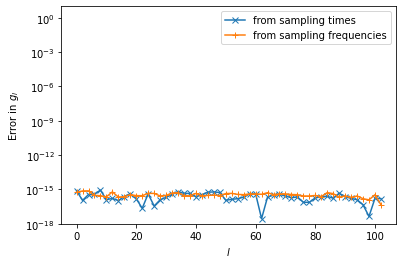

In [8]:
plt.semilogy(ls[::2], np.abs((gl_reconst_from_tau-gl)[::2]), marker="x", label="from sampling times")
plt.semilogy(ls[::2], np.abs((gl_reconst_from_matsu-gl)[::2]), marker="+", label="from sampling frequencies")
plt.xlabel(r"$l$")
plt.ylabel(r"Error in $g_l$")
plt.ylim([1e-18, 10])
plt.legend()
plt.show()